The code aims to develop models that can predict multiple future time points in data-driven scenarios. Instead of predicting just one future data point, these multi-step prediction models forecast a series of upcoming values. Two main methodologies are employed:

**Single shot predictions:** The entire future time series is forecasted in one go.

**Autoregressive predictions:** The model predicts one future point at a time and uses its own predictions as inputs for subsequent forecasts.

All the designed models in the code will forecast all features for every future time step.

In [ ]:
#Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import all packages

import pandas as pd
import numpy as np
from datetime import timedelta, datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import plotly.graph_objects as go

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('drive/My Drive/final_data_NA3D.xlsx')

In [ ]:
date_time = pd.to_datetime(df.pop('datetime'), format='%d.%m.%Y')

In [ ]:
df.head(6000)

BHP(kg/cm2)  OR(m3/day)  WR(m3/day)  GR(m3/day)     CO(m3)
0      328.778168         0.0       0.000         0.0        0.0
1      328.778168         0.0       0.000         0.0        0.0
2      328.778168         0.0       0.000         0.0        0.0
3      328.778168         0.0       0.000         0.0        0.0
4      328.778168         0.0       0.000         0.0        0.0
...           ...         ...         ...         ...        ...
5995   220.781021       719.0    1123.750     81728.0  5429630.5
5996   220.786896       719.5    1123.875     81664.0  5430350.0
5997   220.790527       707.0    1136.250     80256.0  5431057.0
5998   220.794159       707.0    1136.250     80320.0  5431764.0
5999   220.797791       707.0    1136.125     80256.0  5432471.0

[6000 rows x 5 columns]

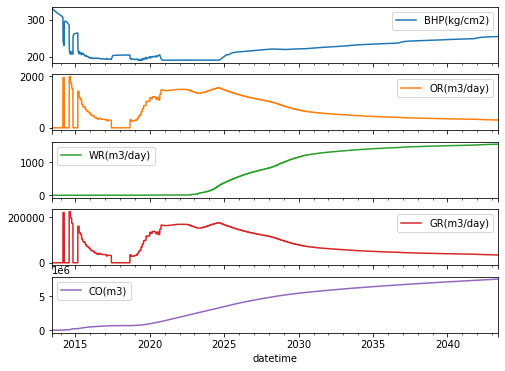

In [ ]:
plot_cols = ['BHP(kg/cm2)', 'OR(m3/day)', 'WR(m3/day)','GR(m3/day)','CO(m3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

count          mean           std         min           25%  \
BHP(kg/cm2)  10957.0  2.228425e+02  2.690785e+01  189.645813  1.996503e+02   
OR(m3/day)   10957.0  6.900789e+02  4.721571e+02    0.000000  3.495000e+02   
WR(m3/day)   10957.0  7.742698e+02  6.419767e+02    0.000000  7.537842e+00   
GR(m3/day)   10957.0  7.830664e+04  5.372015e+04    0.000000  3.955200e+04   
CO(m3)       10957.0  4.213243e+06  2.594496e+06    0.000000  1.362382e+06   

                      50%           75%           max  
BHP(kg/cm2)  2.209015e+02  2.417020e+02  3.287782e+02  
OR(m3/day)   5.020000e+02  1.111000e+03  1.973000e+03  
WR(m3/day)   8.761250e+02  1.425000e+03  1.542000e+03  
GR(m3/day)   5.644400e+04  1.266640e+05  2.238440e+05  
CO(m3)       5.001546e+06  6.589486e+06  7.561194e+06

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day'] = np.log10(timestamp_s * (2 * np.pi / day))

In [ ]:
df.head(6000)

BHP(kg/cm2)  OR(m3/day)  WR(m3/day)  GR(m3/day)     CO(m3)       Day
0      328.778168         0.0       0.000         0.0        0.0  4.998401
1      328.778168         0.0       0.000         0.0        0.0  4.998428
2      328.778168         0.0       0.000         0.0        0.0  4.998456
3      328.778168         0.0       0.000         0.0        0.0  4.998483
4      328.778168         0.0       0.000         0.0        0.0  4.998510
...           ...         ...         ...         ...        ...       ...
5995   220.781021       719.0    1123.750     81728.0  5429630.5  5.137671
5996   220.786896       719.5    1123.875     81664.0  5430350.0  5.137691
5997   220.790527       707.0    1136.250     80256.0  5431057.0  5.137711
5998   220.794159       707.0    1136.250     80320.0  5431764.0  5.137731
5999   220.797791       707.0    1136.125     80256.0  5432471.0  5.137751

[6000 rows x 6 columns]

Text(0.5, 1.0, 'Time of day signal')

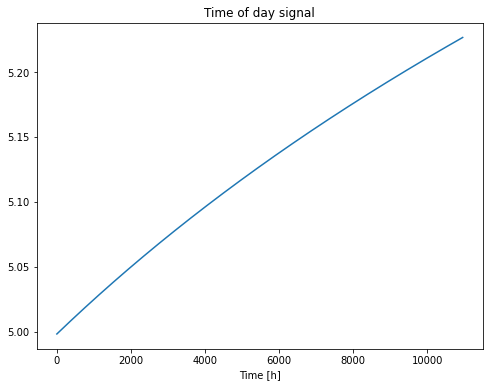

In [ ]:
plt.plot(np.array(df['Day'])[:])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

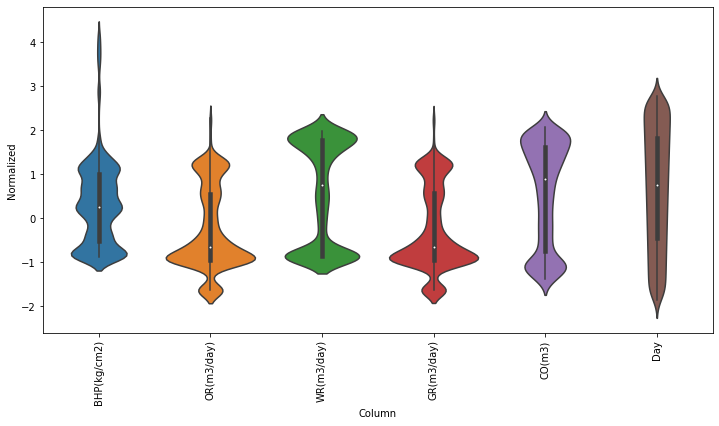

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='BHP(kg/cm2)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 360
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
Label indices: [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

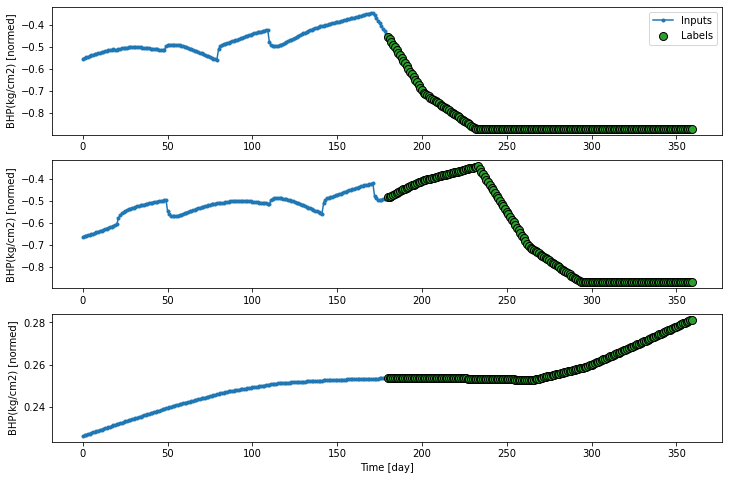

In [ ]:
OUT_STEPS = 180
multi_window = WindowGenerator(input_width=180,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

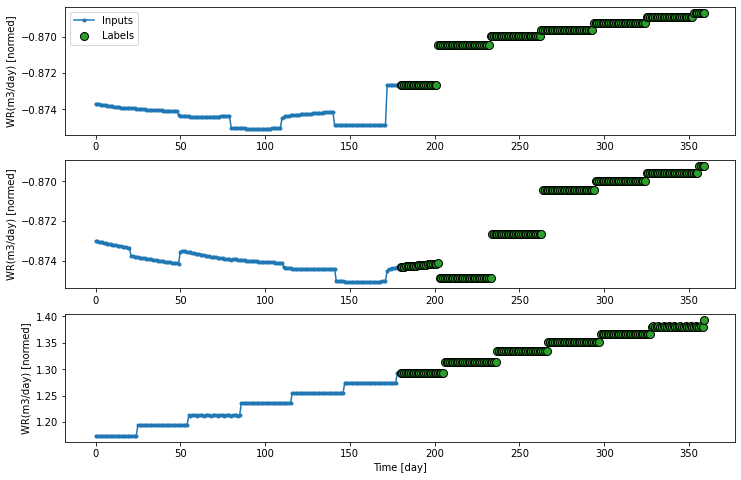

In [ ]:
multi_window.plot(plot_col='WR(m3/day)')

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 180, 6)
Labels shape (batch, time, features): (32, 180, 6)


In [ ]:
num_features

6

58/58 [==============================] - 1s 3ms/step - loss: 5.4385e-04 - mean_absolute_error: 0.0161


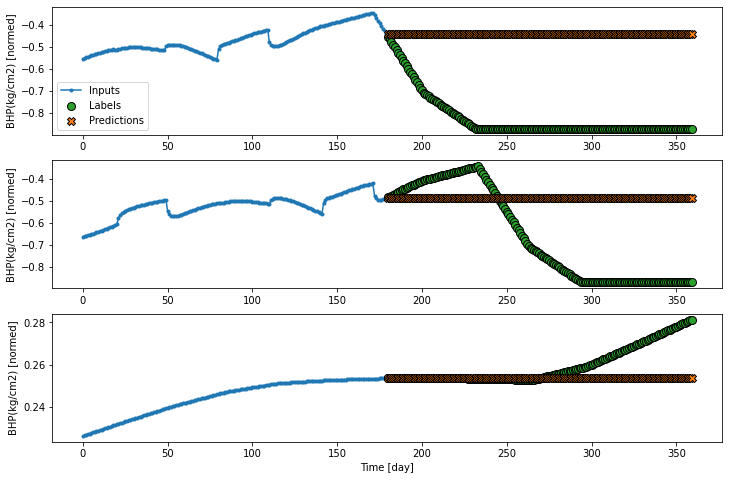

In [ ]:
#Baselines
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

58/58 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0322


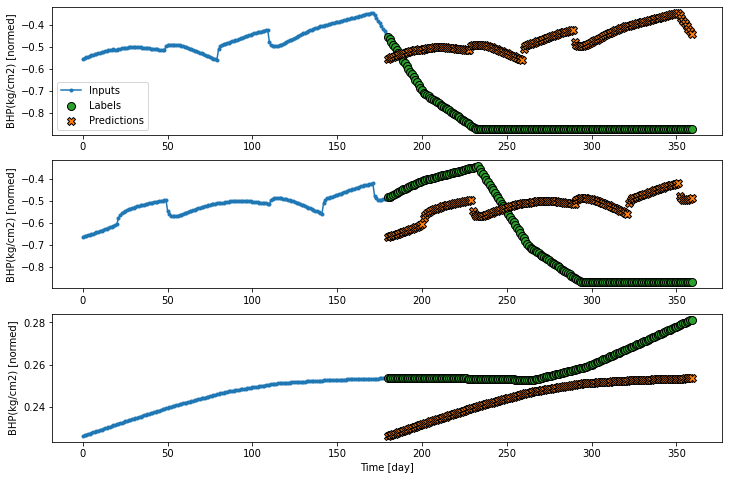

In [ ]:
#RepeatBaseline
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

***Single-shot models***

***LSTM***

In [ ]:
# This returns a multi-layer-perceptron model in Keras.
def get_keras_model(num_hidden_layers,
                    num_neurons_per_layer):
    # create the MLP model.

    # define the layers.
    inputs = tf.keras.Input(shape=(180,6))               # input layer.

    # Add the hidden layers.
    for i in range(num_hidden_layers):
        x = tf.keras.layers.LSTM(num_neurons_per_layer,return_sequences=False)(inputs)

    # output layer.
    x = tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros())(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# This function takes in the hyperparameters and returns a score (Cross validation).
def keras_mlp_cv_score(parameterization, weight=None):

    model = get_keras_model(parameterization.get('num_hidden_layers'),
                            parameterization.get('neurons_per_layer'))

    opt = parameterization.get('optimizer')
    opt = opt.lower()

    learning_rate = parameterization.get('learning_rate')

    if opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif opt == 'rms':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    NUM_EPOCHS = 50

    # Specify the training configuration.
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    data = multi_window.train
    # fit the model using a 20% validation set.
    res = model.fit(data, epochs=NUM_EPOCHS, batch_size=parameterization.get('batch_size'),
                    validation_data=multi_window.val)

    # look at the last 10 epochs. Get the mean and standard deviation of the validation score.
    last10_scores = np.array(res.history['val_loss'][-10:])
    mean = last10_scores.mean()
    sem = last10_scores.std()

    # If the model didn't converge then set a high loss.
    if np.isnan(mean):
        return 9999.0, 0.0

    return mean, sem

In [ ]:
# Define the search space.
parameters=[
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [0.0001, 0.5],
        "log_scale": True,
    },
    {
        "name": "num_hidden_layers",
        "type": "range",
        "bounds": [1, 10],
        "value_type": "int"
    },
    {
        "name": "neurons_per_layer",
        "type": "range",
        "bounds": [1, 300],
        "value_type": "int"
    },
    {
        "name": "batch_size",
        "type": "choice",
        "values": [8, 16, 32, 64, 128, 256],
    },
    {
        "name": "optimizer",
        "type": "choice",
        "values": ['Nadam', 'rms', 'Adam'],
    },
]

In [ ]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 33.7 MB/s 
     |████████████████████████████████| 363 kB 55.0 MB/s 
     |████████████████████████████████| 713 kB 56.0 MB/s 
     |████████████████████████████████| 310 kB 69.5 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=401286beb900c0268bb2dd2a1763e145ce9592b5bb9f64094407d221713da50f
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [ ]:
# import more packages
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

ax_client = AxClient()

# create the experiment.
ax_client.create_experiment(
    name="keras_experiment",
    parameters=parameters,
    objective_name='keras_cv',
    minimize=True)

def evaluate(parameters):
    return {"keras_cv": keras_mlp_cv_score(parameters)}

# Based on the search space, this will use Sobol (https://en.wikipedia.org/wiki/Sobol_sequence) instead of a Guassian Process (GPEI).
#
# From the source code:
#     """We should use only Sobol and not GPEI if:
#     1. there are less continuous parameters in the search space than the sum of
#     options for the choice parameters,
#     2. the number of total iterations in the optimization is known in advance and
#     there are less distinct points in the search space than the known intended
#     number of total iterations.
#     """

# Sobol sequences seem to be better than random for high-dimensional spaces:
# https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

[INFO 06-14 09:37:20] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


[INFO 06-14 09:37:20] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-14 09:37:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 06-14 09:37:20] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "batch_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `i

In [ ]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 06-14 09:37:36] ax.service.ax_client: Generated new trial 0 with parameters {'learning_rate': 0.027885, 'num_hidden_layers': 1, 'neurons_per_layer': 121, 'batch_size': 8, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 9s 15ms/step - loss: 0.1210 - mean_absolute_error: 0.1539 - val_loss: 0.0399 - val_mean_absolute_error: 0.1452
Epoch 2/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0700 - mean_absolute_error: 0.0964 - val_loss: 0.2122 - val_mean_absolute_error: 0.3809
Epoch 3/50
229/229 [==============================] - 3s 13ms/step - loss: 0.1048 - mean_absolute_error: 0.1767 - val_loss: 0.0346 - val_mean_absolute_error: 0.1327
Epoch 4/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0600 - mean_absolute_error: 0.1067 - val_loss: 0.0305 - val_mean_absolute_error: 0.1250
Epoch 5/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0583 - mean_absolute_error: 0.0999 - val_loss: 0.0298 - val_mean_absolute_error: 0.1275
Epoch 6/50
229/229 [==============================] - 3s 14ms/step - loss: 0.0608 - mean_absolute_error: 0.1081 - val_loss: 0.0210 - val_mean_absolute_error: 0.1042
Epoch 7/50

[INFO 06-14 09:41:16] ax.service.ax_client: Completed trial 0 with data: {'keras_cv': (9999.0, 0.0)}.
[INFO 06-14 09:41:16] ax.service.ax_client: Generated new trial 1 with parameters {'learning_rate': 0.000146, 'num_hidden_layers': 1, 'neurons_per_layer': 45, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
229/229 [==============================] - 5s 14ms/step - loss: 0.6109 - mean_absolute_error: 0.6499 - val_loss: 0.6807 - val_mean_absolute_error: 0.7834
Epoch 2/50
229/229 [==============================] - 3s 13ms/step - loss: 0.2376 - mean_absolute_error: 0.3242 - val_loss: 0.2345 - val_mean_absolute_error: 0.4484
Epoch 3/50
229/229 [==============================] - 3s 13ms/step - loss: 0.1347 - mean_absolute_error: 0.1635 - val_loss: 0.1469 - val_mean_absolute_error: 0.3246
Epoch 4/50
229/229 [==============================] - 3s 12ms/step - loss: 0.1088 - mean_absolute_error: 0.1245 - val_loss: 0.1166 - val_mean_absolute_error: 0.2756
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0905 - mean_absolute_error: 0.1036 - val_loss: 0.1081 - val_mean_absolute_error: 0.2602
Epoch 6/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0810 - mean_absolute_error: 0.0943 - val_loss: 0.1013 - val_mean_absolute_error: 0.2554
Epoch 7/50

[INFO 06-14 09:44:46] ax.service.ax_client: Completed trial 1 with data: {'keras_cv': (0.055361, 0.002485)}.
[INFO 06-14 09:44:46] ax.service.ax_client: Generated new trial 2 with parameters {'learning_rate': 0.001107, 'num_hidden_layers': 3, 'neurons_per_layer': 31, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
229/229 [==============================] - 5s 15ms/step - loss: 0.2072 - mean_absolute_error: 0.2498 - val_loss: 0.1254 - val_mean_absolute_error: 0.2694
Epoch 2/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0741 - mean_absolute_error: 0.0962 - val_loss: 0.1017 - val_mean_absolute_error: 0.2471
Epoch 3/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0596 - mean_absolute_error: 0.0772 - val_loss: 0.0939 - val_mean_absolute_error: 0.2481
Epoch 4/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0520 - mean_absolute_error: 0.0682 - val_loss: 0.0812 - val_mean_absolute_error: 0.2281
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0462 - mean_absolute_error: 0.0637 - val_loss: 0.0904 - val_mean_absolute_error: 0.2529
Epoch 6/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0427 - mean_absolute_error: 0.0614 - val_loss: 0.0742 - val_mean_absolute_error: 0.2212
Epoch 7/50

[INFO 06-14 09:48:12] ax.service.ax_client: Completed trial 2 with data: {'keras_cv': (0.051034, 0.002729)}.
[INFO 06-14 09:48:12] ax.service.ax_client: Generated new trial 3 with parameters {'learning_rate': 0.002752, 'num_hidden_layers': 1, 'neurons_per_layer': 20, 'batch_size': 32, 'optimizer': 'Adam'}.


Epoch 1/50
229/229 [==============================] - 4s 13ms/step - loss: 0.1820 - mean_absolute_error: 0.2202 - val_loss: 0.1234 - val_mean_absolute_error: 0.2656
Epoch 2/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0707 - mean_absolute_error: 0.0978 - val_loss: 0.1025 - val_mean_absolute_error: 0.2475
Epoch 3/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0600 - mean_absolute_error: 0.0797 - val_loss: 0.0832 - val_mean_absolute_error: 0.2163
Epoch 4/50
229/229 [==============================] - 3s 11ms/step - loss: 0.0555 - mean_absolute_error: 0.0725 - val_loss: 0.0911 - val_mean_absolute_error: 0.2299
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0516 - mean_absolute_error: 0.0672 - val_loss: 0.0875 - val_mean_absolute_error: 0.2231
Epoch 6/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0524 - mean_absolute_error: 0.0727 - val_loss: 0.0592 - val_mean_absolute_error: 0.1744
Epoch 7/50

[INFO 06-14 09:51:39] ax.service.ax_client: Completed trial 3 with data: {'keras_cv': (0.030965, 0.001788)}.
[INFO 06-14 09:51:39] ax.service.ax_client: Generated new trial 4 with parameters {'learning_rate': 0.0003, 'num_hidden_layers': 1, 'neurons_per_layer': 55, 'batch_size': 128, 'optimizer': 'rms'}.


Epoch 1/50
229/229 [==============================] - 5s 14ms/step - loss: 0.3515 - mean_absolute_error: 0.4265 - val_loss: 0.2519 - val_mean_absolute_error: 0.4697
Epoch 2/50
229/229 [==============================] - 3s 12ms/step - loss: 0.1163 - mean_absolute_error: 0.1351 - val_loss: 0.1115 - val_mean_absolute_error: 0.2708
Epoch 3/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0846 - mean_absolute_error: 0.0989 - val_loss: 0.0948 - val_mean_absolute_error: 0.2515
Epoch 4/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0714 - mean_absolute_error: 0.0845 - val_loss: 0.0846 - val_mean_absolute_error: 0.2402
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0633 - mean_absolute_error: 0.0771 - val_loss: 0.0814 - val_mean_absolute_error: 0.2338
Epoch 6/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0574 - mean_absolute_error: 0.0737 - val_loss: 0.0799 - val_mean_absolute_error: 0.2337
Epoch 7/50

[INFO 06-14 09:54:57] ax.service.ax_client: Completed trial 4 with data: {'keras_cv': (0.070474, 0.003712)}.
[INFO 06-14 09:54:57] ax.service.ax_client: Generated new trial 5 with parameters {'learning_rate': 0.200153, 'num_hidden_layers': 7, 'neurons_per_layer': 36, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 13ms/step - loss: 0.1882 - mean_absolute_error: 0.2350 - val_loss: 0.7781 - val_mean_absolute_error: 0.6279
Epoch 2/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0739 - mean_absolute_error: 0.1298 - val_loss: 0.7422 - val_mean_absolute_error: 0.5999
Epoch 3/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0787 - mean_absolute_error: 0.1467 - val_loss: 0.7097 - val_mean_absolute_error: 0.6030
Epoch 4/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0740 - mean_absolute_error: 0.1412 - val_loss: 0.6525 - val_mean_absolute_error: 0.6064
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0720 - mean_absolute_error: 0.1287 - val_loss: 1.0987 - val_mean_absolute_error: 0.7982
Epoch 6/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0652 - mean_absolute_error: 0.1209 - val_loss: 0.2821 - val_mean_absolute_error: 0.3793
Epoch 7/50

[INFO 06-14 09:58:19] ax.service.ax_client: Completed trial 5 with data: {'keras_cv': (9999.0, 0.0)}.
[INFO 06-14 09:58:19] ax.service.ax_client: Generated new trial 6 with parameters {'learning_rate': 0.001586, 'num_hidden_layers': 5, 'neurons_per_layer': 83, 'batch_size': 16, 'optimizer': 'rms'}.


Epoch 1/50
229/229 [==============================] - 5s 14ms/step - loss: 0.1126 - mean_absolute_error: 0.1556 - val_loss: 0.1245 - val_mean_absolute_error: 0.3084
Epoch 2/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0542 - mean_absolute_error: 0.0850 - val_loss: 0.0769 - val_mean_absolute_error: 0.2251
Epoch 3/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0382 - mean_absolute_error: 0.0699 - val_loss: 0.0513 - val_mean_absolute_error: 0.1638
Epoch 4/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0353 - mean_absolute_error: 0.0634 - val_loss: 0.0553 - val_mean_absolute_error: 0.1795
Epoch 5/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0302 - mean_absolute_error: 0.0590 - val_loss: 0.0563 - val_mean_absolute_error: 0.1860
Epoch 6/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0273 - mean_absolute_error: 0.0550 - val_loss: 0.0414 - val_mean_absolute_error: 0.1513
Epoch 7/50

[INFO 06-14 10:01:40] ax.service.ax_client: Completed trial 6 with data: {'keras_cv': (0.018598, 0.001346)}.
[INFO 06-14 10:01:40] ax.service.ax_client: Generated new trial 7 with parameters {'learning_rate': 0.00059, 'num_hidden_layers': 6, 'neurons_per_layer': 35, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 14ms/step - loss: 0.3228 - mean_absolute_error: 0.3754 - val_loss: 0.2044 - val_mean_absolute_error: 0.4052
Epoch 2/50
229/229 [==============================] - 3s 12ms/step - loss: 0.1087 - mean_absolute_error: 0.1366 - val_loss: 0.1539 - val_mean_absolute_error: 0.3149
Epoch 3/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0805 - mean_absolute_error: 0.1069 - val_loss: 0.1268 - val_mean_absolute_error: 0.2749
Epoch 4/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.0937 - val_loss: 0.1064 - val_mean_absolute_error: 0.2549
Epoch 5/50
229/229 [==============================] - 3s 12ms/step - loss: 0.0602 - mean_absolute_error: 0.0858 - val_loss: 0.0965 - val_mean_absolute_error: 0.2448
Epoch 6/50
229/229 [==============================] - 3s 13ms/step - loss: 0.0532 - mean_absolute_error: 0.0775 - val_loss: 0.0934 - val_mean_absolute_error: 0.2473
Epoch 7/50

[INFO 06-14 10:05:07] ax.service.ax_client: Completed trial 7 with data: {'keras_cv': (0.070839, 0.002657)}.
[INFO 06-14 10:05:07] ax.service.ax_client: Generated new trial 8 with parameters {'learning_rate': 0.008748, 'num_hidden_layers': 2, 'neurons_per_layer': 236, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.0984 - mean_absolute_error: 0.1328 - val_loss: 0.0093 - val_mean_absolute_error: 0.0752
Epoch 2/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0550 - mean_absolute_error: 0.0776 - val_loss: 0.0190 - val_mean_absolute_error: 0.1024
Epoch 3/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0489 - mean_absolute_error: 0.0732 - val_loss: 0.0127 - val_mean_absolute_error: 0.0821
Epoch 4/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0491 - mean_absolute_error: 0.0730 - val_loss: 0.0134 - val_mean_absolute_error: 0.0810
Epoch 5/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0405 - mean_absolute_error: 0.0608 - val_loss: 0.0296 - val_mean_absolute_error: 0.1381
Epoch 6/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0393 - mean_absolute_error: 0.0598 - val_loss: 0.0109 - val_mean_absolute_error: 0.0779
Epoch 7/50

[INFO 06-14 10:08:51] ax.service.ax_client: Completed trial 8 with data: {'keras_cv': (0.003289, 0.000524)}.
[INFO 06-14 10:08:51] ax.service.ax_client: Generated new trial 9 with parameters {'learning_rate': 0.002292, 'num_hidden_layers': 4, 'neurons_per_layer': 259, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 17ms/step - loss: 0.1785 - mean_absolute_error: 0.2259 - val_loss: 0.0647 - val_mean_absolute_error: 0.2039
Epoch 2/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0702 - mean_absolute_error: 0.1082 - val_loss: 0.0473 - val_mean_absolute_error: 0.1703
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0665 - mean_absolute_error: 0.0961 - val_loss: 0.0373 - val_mean_absolute_error: 0.1479
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0578 - mean_absolute_error: 0.0775 - val_loss: 0.0321 - val_mean_absolute_error: 0.1243
Epoch 5/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0577 - mean_absolute_error: 0.0770 - val_loss: 0.0341 - val_mean_absolute_error: 0.1269
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0465 - mean_absolute_error: 0.0673 - val_loss: 0.0338 - val_mean_absolute_error: 0.1272
Epoch 7/50

[INFO 06-14 10:12:41] ax.service.ax_client: Completed trial 9 with data: {'keras_cv': (0.008298, 0.000869)}.
[INFO 06-14 10:12:42] ax.service.ax_client: Generated new trial 10 with parameters {'learning_rate': 0.00664, 'num_hidden_layers': 1, 'neurons_per_layer': 275, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.0905 - mean_absolute_error: 0.1240 - val_loss: 0.0229 - val_mean_absolute_error: 0.1171
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0540 - mean_absolute_error: 0.0785 - val_loss: 0.0139 - val_mean_absolute_error: 0.0895
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0536 - mean_absolute_error: 0.0776 - val_loss: 0.0056 - val_mean_absolute_error: 0.0507
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0462 - mean_absolute_error: 0.0695 - val_loss: 0.0130 - val_mean_absolute_error: 0.0817
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0444 - mean_absolute_error: 0.0654 - val_loss: 0.0059 - val_mean_absolute_error: 0.0623
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0461 - mean_absolute_error: 0.0698 - val_loss: 0.0065 - val_mean_absolute_error: 0.0562
Epoch 7/50

[INFO 06-14 10:16:38] ax.service.ax_client: Completed trial 10 with data: {'keras_cv': (0.003564, 0.000477)}.
[INFO 06-14 10:16:38] ax.service.ax_client: Generated new trial 11 with parameters {'learning_rate': 0.02121, 'num_hidden_layers': 3, 'neurons_per_layer': 282, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 18ms/step - loss: 0.2917 - mean_absolute_error: 0.2779 - val_loss: 0.0567 - val_mean_absolute_error: 0.1568
Epoch 2/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0777 - mean_absolute_error: 0.1221 - val_loss: 0.0544 - val_mean_absolute_error: 0.1765
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0665 - mean_absolute_error: 0.1061 - val_loss: 0.0622 - val_mean_absolute_error: 0.1898
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0656 - mean_absolute_error: 0.1057 - val_loss: 0.0488 - val_mean_absolute_error: 0.1645
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0631 - mean_absolute_error: 0.1007 - val_loss: 0.0471 - val_mean_absolute_error: 0.1592
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0609 - mean_absolute_error: 0.0949 - val_loss: 0.2745 - val_mean_absolute_error: 0.3442
Epoch 7/50

[INFO 06-14 10:20:17] ax.service.ax_client: Completed trial 11 with data: {'keras_cv': (0.179752, 0.03372)}.
[INFO 06-14 10:20:18] ax.service.ax_client: Generated new trial 12 with parameters {'learning_rate': 0.002412, 'num_hidden_layers': 1, 'neurons_per_layer': 224, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 17ms/step - loss: 0.1790 - mean_absolute_error: 0.2607 - val_loss: 0.1481 - val_mean_absolute_error: 0.3303
Epoch 2/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0759 - mean_absolute_error: 0.1235 - val_loss: 0.0894 - val_mean_absolute_error: 0.2203
Epoch 3/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0591 - mean_absolute_error: 0.0894 - val_loss: 0.0641 - val_mean_absolute_error: 0.1858
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0487 - mean_absolute_error: 0.0782 - val_loss: 0.0639 - val_mean_absolute_error: 0.1921
Epoch 5/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0793 - mean_absolute_error: 0.1209 - val_loss: 0.0630 - val_mean_absolute_error: 0.1859
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0601 - mean_absolute_error: 0.1017 - val_loss: 0.0491 - val_mean_absolute_error: 0.1602
Epoch 7/50

[INFO 06-14 10:23:47] ax.service.ax_client: Completed trial 12 with data: {'keras_cv': (0.036455, 0.004581)}.
[INFO 06-14 10:23:52] ax.service.ax_client: Generated new trial 13 with parameters {'learning_rate': 0.005156, 'num_hidden_layers': 3, 'neurons_per_layer': 247, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 17ms/step - loss: 0.1070 - mean_absolute_error: 0.1474 - val_loss: 0.0278 - val_mean_absolute_error: 0.1254
Epoch 2/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0578 - mean_absolute_error: 0.0840 - val_loss: 0.0269 - val_mean_absolute_error: 0.1221
Epoch 3/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0420 - mean_absolute_error: 0.0694 - val_loss: 0.0113 - val_mean_absolute_error: 0.0801
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0408 - mean_absolute_error: 0.0640 - val_loss: 0.0061 - val_mean_absolute_error: 0.0544
Epoch 5/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0459 - mean_absolute_error: 0.0710 - val_loss: 0.0122 - val_mean_absolute_error: 0.0771
Epoch 6/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0353 - mean_absolute_error: 0.0595 - val_loss: 0.0131 - val_mean_absolute_error: 0.0878
Epoch 7/50

[INFO 06-14 10:27:24] ax.service.ax_client: Completed trial 13 with data: {'keras_cv': (0.005565, 0.002103)}.
[INFO 06-14 10:27:27] ax.service.ax_client: Generated new trial 14 with parameters {'learning_rate': 0.006107, 'num_hidden_layers': 1, 'neurons_per_layer': 241, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 17ms/step - loss: 0.1337 - mean_absolute_error: 0.1689 - val_loss: 0.0377 - val_mean_absolute_error: 0.1438
Epoch 2/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0612 - mean_absolute_error: 0.0812 - val_loss: 0.0271 - val_mean_absolute_error: 0.1155
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0525 - mean_absolute_error: 0.0770 - val_loss: 0.0268 - val_mean_absolute_error: 0.1085
Epoch 4/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0496 - mean_absolute_error: 0.0761 - val_loss: 0.0229 - val_mean_absolute_error: 0.1118
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0534 - mean_absolute_error: 0.0764 - val_loss: 0.0205 - val_mean_absolute_error: 0.0992
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0377 - mean_absolute_error: 0.0622 - val_loss: 0.0209 - val_mean_absolute_error: 0.1049
Epoch 7/50

[INFO 06-14 10:31:18] ax.service.ax_client: Completed trial 14 with data: {'keras_cv': (0.00793, 0.003399)}.
[INFO 06-14 10:31:19] ax.service.ax_client: Generated new trial 15 with parameters {'learning_rate': 0.002569, 'num_hidden_layers': 2, 'neurons_per_layer': 274, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.1112 - mean_absolute_error: 0.1502 - val_loss: 0.0329 - val_mean_absolute_error: 0.1323
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0600 - mean_absolute_error: 0.0882 - val_loss: 0.0271 - val_mean_absolute_error: 0.1126
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0462 - mean_absolute_error: 0.0745 - val_loss: 0.0157 - val_mean_absolute_error: 0.0879
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0326 - mean_absolute_error: 0.0576 - val_loss: 0.0374 - val_mean_absolute_error: 0.1503
Epoch 5/50
229/229 [==============================] - 5s 20ms/step - loss: 0.0495 - mean_absolute_error: 0.0731 - val_loss: 0.0166 - val_mean_absolute_error: 0.0930
Epoch 6/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0332 - mean_absolute_error: 0.0573 - val_loss: 0.0156 - val_mean_absolute_error: 0.0867
Epoch 7/50

[INFO 06-14 10:35:06] ax.service.ax_client: Completed trial 15 with data: {'keras_cv': (0.005309, 0.001832)}.
[INFO 06-14 10:35:08] ax.service.ax_client: Generated new trial 16 with parameters {'learning_rate': 0.006876, 'num_hidden_layers': 2, 'neurons_per_layer': 251, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 5s 17ms/step - loss: 0.0977 - mean_absolute_error: 0.1331 - val_loss: 0.0553 - val_mean_absolute_error: 0.1871
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0620 - mean_absolute_error: 0.0919 - val_loss: 0.0204 - val_mean_absolute_error: 0.0998
Epoch 3/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0472 - mean_absolute_error: 0.0705 - val_loss: 0.0188 - val_mean_absolute_error: 0.0958
Epoch 4/50
229/229 [==============================] - 4s 15ms/step - loss: 0.0394 - mean_absolute_error: 0.0615 - val_loss: 0.0159 - val_mean_absolute_error: 0.0831
Epoch 5/50
229/229 [==============================] - 3s 15ms/step - loss: 0.0396 - mean_absolute_error: 0.0650 - val_loss: 0.0115 - val_mean_absolute_error: 0.0666
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0391 - mean_absolute_error: 0.0629 - val_loss: 0.0137 - val_mean_absolute_error: 0.0813
Epoch 7/50

[INFO 06-14 10:38:40] ax.service.ax_client: Completed trial 16 with data: {'keras_cv': (0.002346, 0.000709)}.
[INFO 06-14 10:38:41] ax.service.ax_client: Generated new trial 17 with parameters {'learning_rate': 0.004792, 'num_hidden_layers': 1, 'neurons_per_layer': 266, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.0927 - mean_absolute_error: 0.1308 - val_loss: 0.0201 - val_mean_absolute_error: 0.1068
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0605 - mean_absolute_error: 0.0856 - val_loss: 0.0060 - val_mean_absolute_error: 0.0594
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0483 - mean_absolute_error: 0.0714 - val_loss: 0.0134 - val_mean_absolute_error: 0.0919
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0386 - mean_absolute_error: 0.0676 - val_loss: 0.0049 - val_mean_absolute_error: 0.0518
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0365 - mean_absolute_error: 0.0578 - val_loss: 0.0083 - val_mean_absolute_error: 0.0714
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0302 - mean_absolute_error: 0.0544 - val_loss: 0.0118 - val_mean_absolute_error: 0.0774
Epoch 7/50

[INFO 06-14 10:42:21] ax.service.ax_client: Completed trial 17 with data: {'keras_cv': (0.012016, 0.012222)}.
[INFO 06-14 10:42:25] ax.service.ax_client: Generated new trial 18 with parameters {'learning_rate': 0.003059, 'num_hidden_layers': 4, 'neurons_per_layer': 300, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.1248 - mean_absolute_error: 0.1697 - val_loss: 0.0356 - val_mean_absolute_error: 0.1257
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0599 - mean_absolute_error: 0.0866 - val_loss: 0.0146 - val_mean_absolute_error: 0.0879
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0485 - mean_absolute_error: 0.0759 - val_loss: 0.0112 - val_mean_absolute_error: 0.0745
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0325 - mean_absolute_error: 0.0573 - val_loss: 0.0065 - val_mean_absolute_error: 0.0566
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0355 - mean_absolute_error: 0.0624 - val_loss: 0.0130 - val_mean_absolute_error: 0.0742
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0290 - mean_absolute_error: 0.0525 - val_loss: 0.0142 - val_mean_absolute_error: 0.0851
Epoch 7/50

[INFO 06-14 10:46:06] ax.service.ax_client: Completed trial 18 with data: {'keras_cv': (0.00203, 0.000584)}.
[INFO 06-14 10:46:07] ax.service.ax_client: Generated new trial 19 with parameters {'learning_rate': 0.003053, 'num_hidden_layers': 3, 'neurons_per_layer': 300, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 19ms/step - loss: 0.1163 - mean_absolute_error: 0.1544 - val_loss: 0.0297 - val_mean_absolute_error: 0.1235
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0582 - mean_absolute_error: 0.0803 - val_loss: 0.0191 - val_mean_absolute_error: 0.1019
Epoch 3/50
229/229 [==============================] - 4s 19ms/step - loss: 0.0505 - mean_absolute_error: 0.0755 - val_loss: 0.0180 - val_mean_absolute_error: 0.0929
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0452 - mean_absolute_error: 0.0690 - val_loss: 0.0345 - val_mean_absolute_error: 0.1322
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0339 - mean_absolute_error: 0.0567 - val_loss: 0.0193 - val_mean_absolute_error: 0.1006
Epoch 6/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0344 - mean_absolute_error: 0.0570 - val_loss: 0.0103 - val_mean_absolute_error: 0.0663
Epoch 7/50

[INFO 06-14 10:50:03] ax.service.ax_client: Completed trial 19 with data: {'keras_cv': (0.003192, 0.000487)}.
[INFO 06-14 10:50:05] ax.service.ax_client: Generated new trial 20 with parameters {'learning_rate': 0.002618, 'num_hidden_layers': 3, 'neurons_per_layer': 300, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.1506 - mean_absolute_error: 0.1968 - val_loss: 0.0561 - val_mean_absolute_error: 0.1730
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0657 - mean_absolute_error: 0.0897 - val_loss: 0.0257 - val_mean_absolute_error: 0.1066
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0498 - mean_absolute_error: 0.0783 - val_loss: 0.0188 - val_mean_absolute_error: 0.1003
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0455 - mean_absolute_error: 0.0722 - val_loss: 0.0296 - val_mean_absolute_error: 0.1168
Epoch 5/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0334 - mean_absolute_error: 0.0587 - val_loss: 0.0280 - val_mean_absolute_error: 0.1162
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0293 - mean_absolute_error: 0.0555 - val_loss: 0.0242 - val_mean_absolute_error: 0.1062
Epoch 7/50

[INFO 06-14 10:53:53] ax.service.ax_client: Completed trial 20 with data: {'keras_cv': (0.006714, 0.001244)}.
[INFO 06-14 10:53:55] ax.service.ax_client: Generated new trial 21 with parameters {'learning_rate': 0.004113, 'num_hidden_layers': 4, 'neurons_per_layer': 279, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 19ms/step - loss: 0.1188 - mean_absolute_error: 0.1620 - val_loss: 0.0334 - val_mean_absolute_error: 0.1333
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0677 - mean_absolute_error: 0.0917 - val_loss: 0.0418 - val_mean_absolute_error: 0.1612
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0553 - mean_absolute_error: 0.0791 - val_loss: 0.0260 - val_mean_absolute_error: 0.1288
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0455 - mean_absolute_error: 0.0685 - val_loss: 0.0143 - val_mean_absolute_error: 0.0840
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0447 - mean_absolute_error: 0.0709 - val_loss: 0.0356 - val_mean_absolute_error: 0.1498
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0416 - mean_absolute_error: 0.0668 - val_loss: 0.0154 - val_mean_absolute_error: 0.0827
Epoch 7/50

[INFO 06-14 10:57:24] ax.service.ax_client: Completed trial 21 with data: {'keras_cv': (0.00611, 0.001126)}.
[INFO 06-14 10:57:25] ax.service.ax_client: Generated new trial 22 with parameters {'learning_rate': 0.001694, 'num_hidden_layers': 6, 'neurons_per_layer': 300, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 18ms/step - loss: 0.1109 - mean_absolute_error: 0.1556 - val_loss: 0.0371 - val_mean_absolute_error: 0.1443
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0620 - mean_absolute_error: 0.0908 - val_loss: 0.0275 - val_mean_absolute_error: 0.1157
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0531 - mean_absolute_error: 0.0837 - val_loss: 0.0226 - val_mean_absolute_error: 0.1104
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0316 - mean_absolute_error: 0.0581 - val_loss: 0.0171 - val_mean_absolute_error: 0.0934
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0279 - mean_absolute_error: 0.0546 - val_loss: 0.0216 - val_mean_absolute_error: 0.1085
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0281 - mean_absolute_error: 0.0545 - val_loss: 0.0128 - val_mean_absolute_error: 0.0783
Epoch 7/50

[INFO 06-14 11:01:18] ax.service.ax_client: Completed trial 22 with data: {'keras_cv': (0.003669, 0.000689)}.
[INFO 06-14 11:01:20] ax.service.ax_client: Generated new trial 23 with parameters {'learning_rate': 0.002334, 'num_hidden_layers': 5, 'neurons_per_layer': 300, 'batch_size': 64, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 20ms/step - loss: 0.1254 - mean_absolute_error: 0.1746 - val_loss: 0.0510 - val_mean_absolute_error: 0.1660
Epoch 2/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0658 - mean_absolute_error: 0.0933 - val_loss: 0.0417 - val_mean_absolute_error: 0.1545
Epoch 3/50
229/229 [==============================] - 4s 19ms/step - loss: 0.0492 - mean_absolute_error: 0.0744 - val_loss: 0.0496 - val_mean_absolute_error: 0.1693
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0364 - mean_absolute_error: 0.0623 - val_loss: 0.0380 - val_mean_absolute_error: 0.1486
Epoch 5/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0307 - mean_absolute_error: 0.0565 - val_loss: 0.0360 - val_mean_absolute_error: 0.1392
Epoch 6/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0294 - mean_absolute_error: 0.0546 - val_loss: 0.0319 - val_mean_absolute_error: 0.1275
Epoch 7/50

[INFO 06-14 11:05:10] ax.service.ax_client: Completed trial 23 with data: {'keras_cv': (0.007015, 0.000917)}.
[INFO 06-14 11:05:11] ax.service.ax_client: Generated new trial 24 with parameters {'learning_rate': 0.001095, 'num_hidden_layers': 7, 'neurons_per_layer': 300, 'batch_size': 256, 'optimizer': 'Nadam'}.


Epoch 1/50
229/229 [==============================] - 6s 19ms/step - loss: 0.1361 - mean_absolute_error: 0.1839 - val_loss: 0.0625 - val_mean_absolute_error: 0.1876
Epoch 2/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0649 - mean_absolute_error: 0.0895 - val_loss: 0.0360 - val_mean_absolute_error: 0.1321
Epoch 3/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0507 - mean_absolute_error: 0.0758 - val_loss: 0.0484 - val_mean_absolute_error: 0.1694
Epoch 4/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0379 - mean_absolute_error: 0.0666 - val_loss: 0.0397 - val_mean_absolute_error: 0.1424
Epoch 5/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0327 - mean_absolute_error: 0.0641 - val_loss: 0.0271 - val_mean_absolute_error: 0.1219
Epoch 6/50
229/229 [==============================] - 4s 18ms/step - loss: 0.0271 - mean_absolute_error: 0.0547 - val_loss: 0.0314 - val_mean_absolute_error: 0.1348
Epoch 7/50

[INFO 06-14 11:09:01] ax.service.ax_client: Completed trial 24 with data: {'keras_cv': (0.010546, 0.001342)}.


In [ ]:
# look at all the trials.
ax_client.get_trials_data_frame().sort_values('trial_index')

keras_cv  trial_index arm_name  learning_rate  num_hidden_layers  \
0   9999.000000            0      0_0       0.027885                  1   
3      0.055361            1      1_0       0.000146                  1   
15     0.051034            2      2_0       0.001107                  3   
18     0.030965            3      3_0       0.002752                  1   
19     0.070474            4      4_0       0.000300                  1   
20  9999.000000            5      5_0       0.200153                  7   
21     0.018598            6      6_0       0.001586                  5   
22     0.070839            7      7_0       0.000590                  6   
23     0.003289            8      8_0       0.008748                  2   
24     0.008298            9      9_0       0.002292                  4   
1      0.003564           10     10_0       0.006640                  1   
2      0.179752           11     11_0       0.021210                  3   
4      0.036455           12     12_0       0.002412                  1   
5      0.005565           13     13_0       0.005156                  3   
6      0.007930           14     14_0       0.006107                  1   
7      0.005309           15     15_0       0.002569                  2   
8      0.002346           16     16_0       0.006876                  2   
9      0.012016           17     17_0       0.004792                  1   
10     0.002030           18     18_0       0.003059                  4   
11     0.003192           19     19_0       0.003053                  3   
12     0.006714           20     20_0       0.002618                  3   
13     0.006110           21     21_0       0.004113                  4   
14     0.003669           22     22_0       0.001694                  6   
16     0.007015           23     23_0       0.002334                  5   
17     0.010546           24     24_0       0.001095                  7   

    neurons_per_layer  batch_size optimizer trial_status generation_method  
0                 121           8     Nadam    COMPLETED             Sobol  
3                  45          64       rms    COMPLETED             Sobol  
15                 31          64       rms    COMPLETED             Sobol  
18                 20          32      Adam    COMPLETED             Sobol  
19                 55         128       rms    COMPLETED             Sobol  
20                 36          64     Nadam    COMPLETED             Sobol  
21                 83          16       rms    COMPLETED             Sobol  
22                 35         128     Nadam    COMPLETED             Sobol  
23                236          64     Nadam    COMPLETED             Sobol  
24                259          64     Nadam    COMPLETED             Sobol  
1                 275         128     Nadam    COMPLETED              GPEI  
2                 282          64     Nadam    COMPLETED              GPEI  
4                 224         128     Nadam    COMPLETED              GPEI  
5                 247          64     Nadam    COMPLETED              GPEI  
6                 241          64     Nadam    COMPLETED              GPEI  
7                 274         128     Nadam    COMPLETED              GPEI  
8                 251         128     Nadam    COMPLETED              GPEI  
9                 266         128     Nadam    COMPLETED              GPEI  
10                300         128     Nadam    COMPLETED              GPEI  
11                300          64     Nadam    COMPLETED              GPEI  
12                300         128     Nadam    COMPLETED              GPEI  
13                279         128     Nadam    COMPLETED              GPEI  
14                300          64     Nadam    COMPLETED              GPEI  
16                300          64     Nadam    COMPLETED              GPEI  
17                300         256     Nadam    COMPLETED              GPEI

In [ ]:
best_parameters, values = ax_client.get_best_parameters()

# the best set of parameters.
for k in best_parameters.items():
  print(k)

print()

# the best score achieved.
means, covariances = values
print(means)

('learning_rate', 0.0030591669863343504)
('num_hidden_layers', 4)
('neurons_per_layer', 300)
('batch_size', 128)
('optimizer', 'Nadam')

{'keras_cv': 0.002237184715040936}


In [ ]:
# train the model on the full training set and test.
dense_model = get_keras_model(best_parameters['num_hidden_layers'],
                              best_parameters['neurons_per_layer'])

opt = best_parameters['optimizer']
opt = opt.lower()

learning_rate = best_parameters['learning_rate']

if opt == 'Nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
elif opt == 'rms':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

NUM_EPOCHS = 50

# Specify the training configuration.
dense_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsoluteError()])

data = multi_window.train
res = dense_model.fit(data, epochs=NUM_EPOCHS, batch_size=best_parameters['batch_size'],validation_data=multi_window.val)

Epoch 1/50
229/229 [==============================] - 6s 20ms/step - loss: 0.1030 - mean_absolute_error: 0.1413 - val_loss: 0.0224 - val_mean_absolute_error: 0.1148
Epoch 2/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0639 - mean_absolute_error: 0.0884 - val_loss: 0.0220 - val_mean_absolute_error: 0.1066
Epoch 3/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0486 - mean_absolute_error: 0.0734 - val_loss: 0.0075 - val_mean_absolute_error: 0.0678
Epoch 4/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0443 - mean_absolute_error: 0.0673 - val_loss: 0.0104 - val_mean_absolute_error: 0.0806
Epoch 5/50
229/229 [==============================] - 4s 17ms/step - loss: 0.0439 - mean_absolute_error: 0.0660 - val_loss: 0.0046 - val_mean_absolute_error: 0.0482
Epoch 6/50
229/229 [==============================] - 4s 16ms/step - loss: 0.0317 - mean_absolute_error: 0.0540 - val_loss: 0.0088 - val_mean_absolute_error: 0.0736
Epoch 7/50

In [ ]:
# Use the model to predict the test values.
multi_val_performance['LSTM'] = dense_model.evaluate(multi_window.test)

24/24 [==============================] - 0s 11ms/step - loss: 0.0170 - mean_absolute_error: 0.1076


In [ ]:
multi_performance['LSTM'] = dense_model.evaluate(multi_window.val)

58/58 [==============================] - 1s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0390


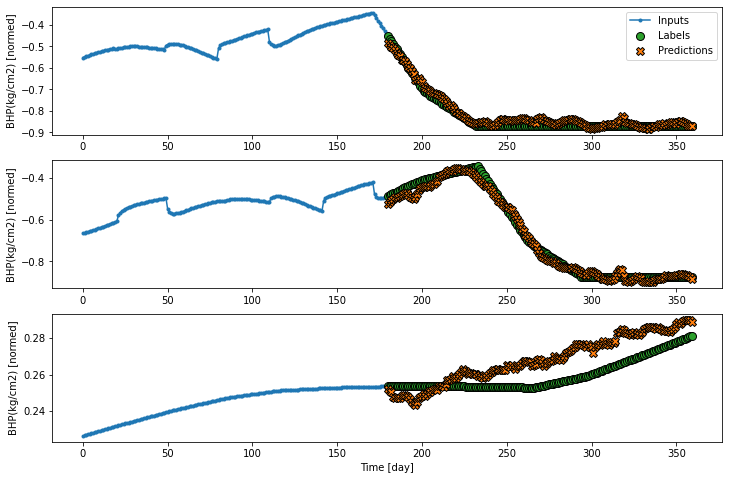

In [ ]:
multi_window.plot(dense_model)

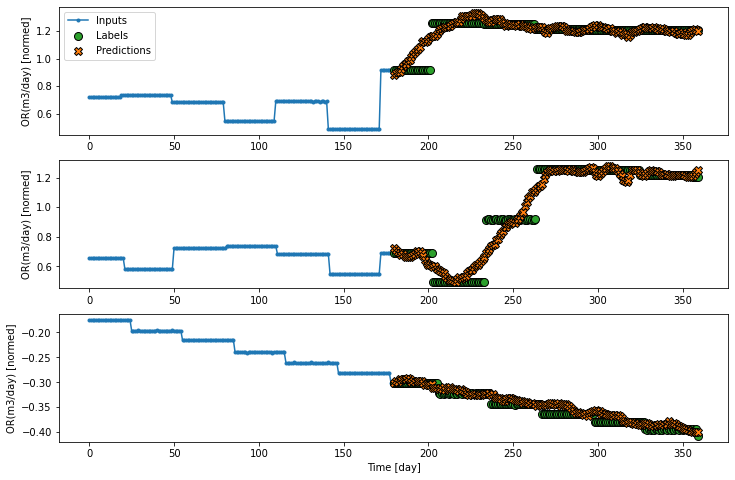

In [ ]:
multi_window.plot(dense_model , plot_col='OR(m3/day)')

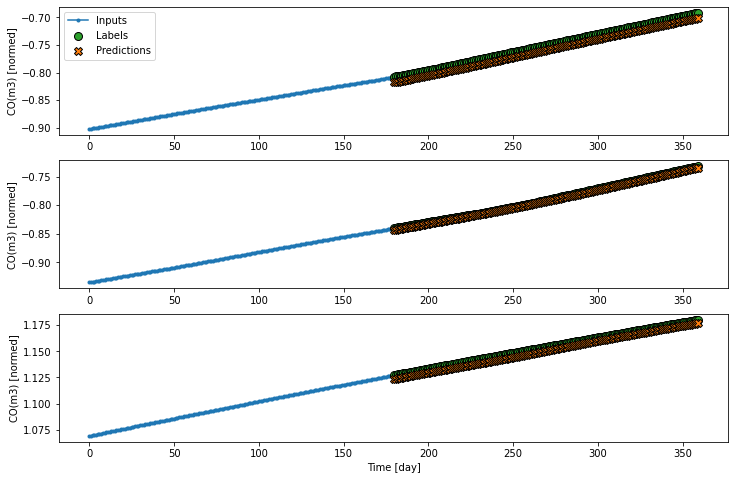

In [ ]:
multi_window.plot(dense_model , plot_col='CO(m3)')

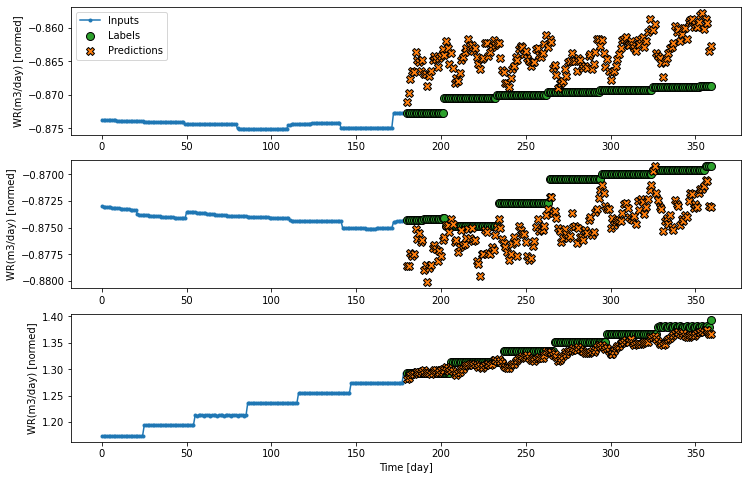

In [ ]:
multi_window.plot(dense_model , plot_col='WR(m3/day)')

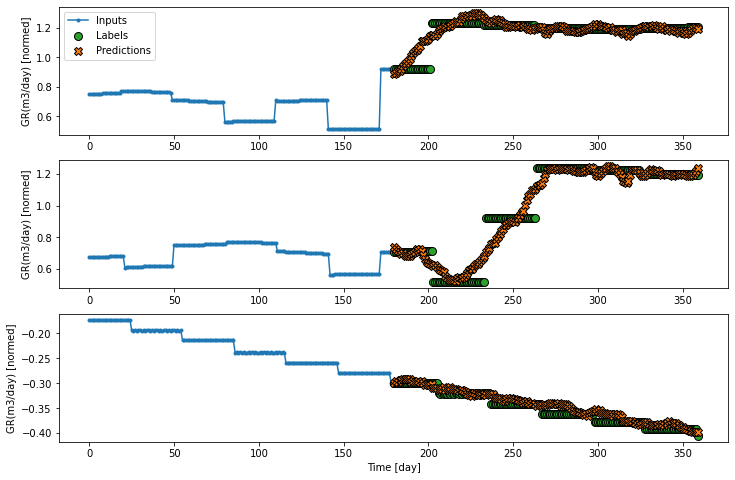

In [ ]:
multi_window.plot(dense_model , plot_col='GR(m3/day)')

***Autoregressive model***

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=142, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 180, 6)


In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=50):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0008),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(feedback_model, multi_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(feedback_model)

Epoch 1/50
229/229 [==============================] - 125s 412ms/step - loss: 0.2987 - mean_absolute_error: 0.3716 - val_loss: 0.3872 - val_mean_absolute_error: 0.5961
Epoch 2/50
229/229 [==============================] - 91s 396ms/step - loss: 0.2859 - mean_absolute_error: 0.3656 - val_loss: 0.4112 - val_mean_absolute_error: 0.6154
Epoch 3/50
229/229 [==============================] - 92s 402ms/step - loss: 0.2634 - mean_absolute_error: 0.3458 - val_loss: 0.4527 - val_mean_absolute_error: 0.6486
Epoch 4/50
229/229 [==============================] - 90s 394ms/step - loss: 0.2096 - mean_absolute_error: 0.3179 - val_loss: 0.6086 - val_mean_absolute_error: 0.7609
Epoch 5/50
229/229 [==============================] - 91s 398ms/step - loss: 0.1833 - mean_absolute_error: 0.3015 - val_loss: 0.5218 - val_mean_absolute_error: 0.7012
Epoch 6/50
229/229 [==============================] - 91s 397ms/step - loss: 0.1628 - mean_absolute_error: 0.2662 - val_loss: 0.3001 - val_mean_absolute_error: 0.50

In [ ]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test)

24/24 [==============================] - 3s 99ms/step - loss: 0.5879 - mean_absolute_error: 0.6913


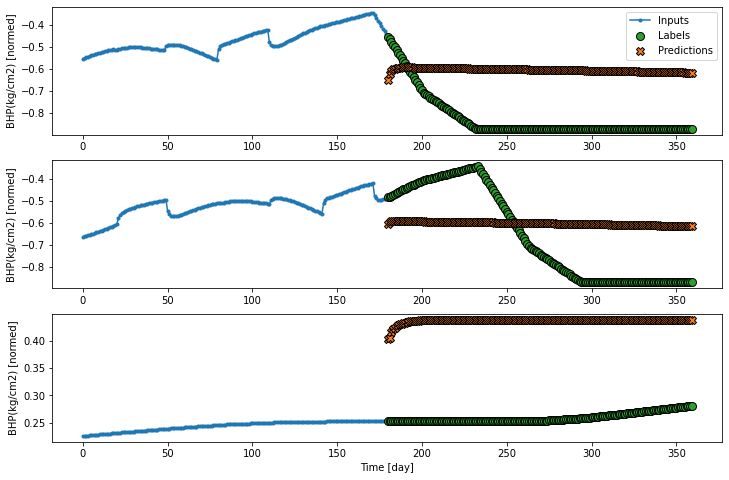

In [ ]:
multi_window.plot(feedback_model)

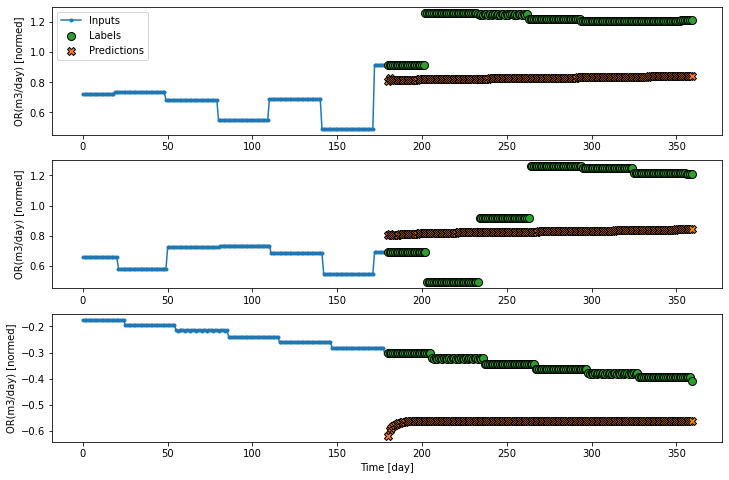

In [ ]:
multi_window.plot(feedback_model , plot_col='OR(m3/day)')

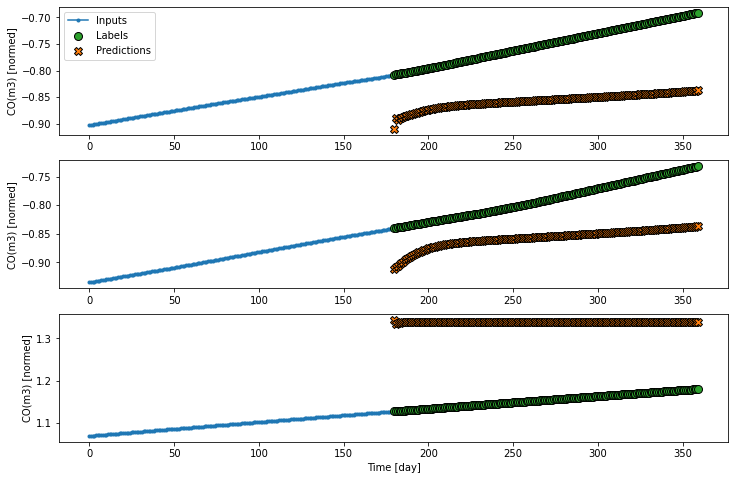

In [ ]:
multi_window.plot(feedback_model , plot_col='CO(m3)')

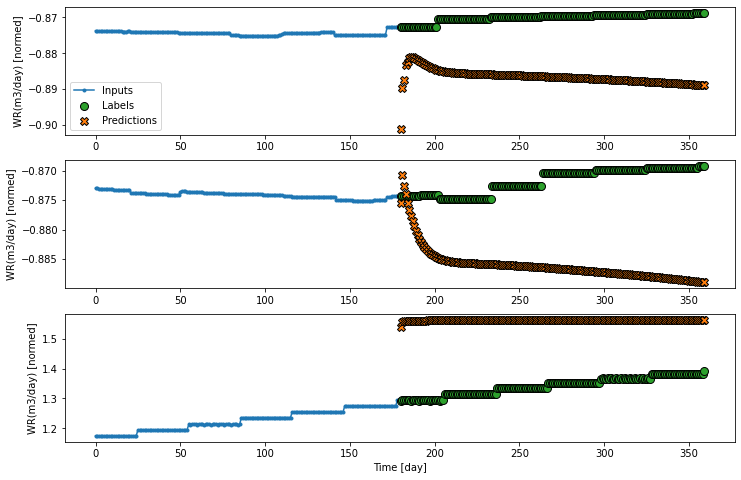

In [ ]:
multi_window.plot(feedback_model , plot_col='WR(m3/day)')

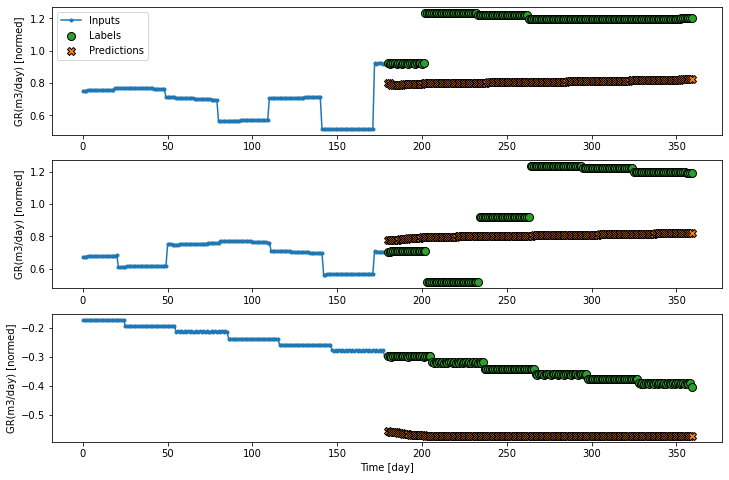

In [ ]:
multi_window.plot(feedback_model , plot_col='GR(m3/day)')

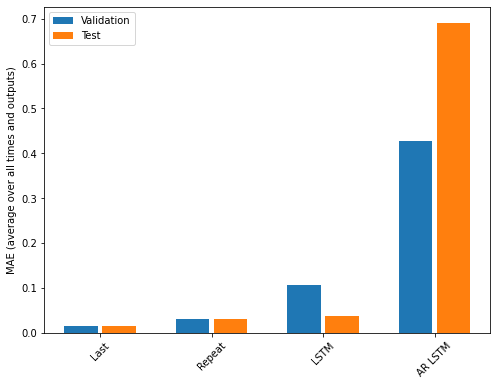

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = dense_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.0158
Repeat  : 0.0312
LSTM    : 0.0390
AR LSTM : 0.6913
